In [271]:
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import string

from bs4 import BeautifulSoup
from shapely.geometry import Point, Polygon
from urllib.parse import urljoin

## Base Map: UK Counties

In [4]:
# Source: https://www.ukpostcode.net/shapefile-of-uk-administrative-counties-wiki-16.html
counties = gpd.read_file('datasets/UK/UK_counties/Map_UK.shp', crs='epsg:32630')

(-185523.71342924781, 871502.387163905, 5468290.709205763, 6808384.907171282)

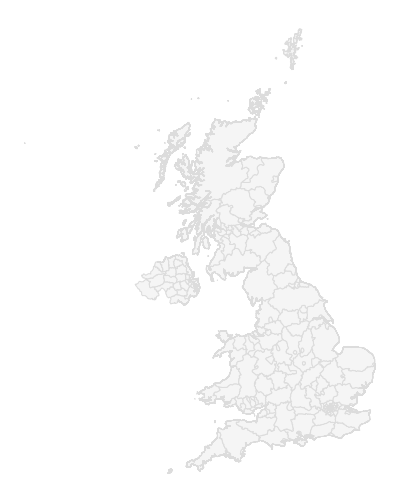

In [5]:
base = counties.plot(figsize=(9,9), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

In [6]:
counties.crs

<Derived Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## UK Postcodes to Coordinates Mapping

In [7]:
# Source (with inner postcodes):
# https://www.ordnancesurvey.co.uk/business-government/products/code-point-open?_ga=2.240870595.1507098495.1663492775-1223826065.1663492775&_gl=1*1df549f*_ga*MTIyMzgyNjA2NS4xNjYzNDkyNzc1*_ga_59ZBN7DVBG*MTY2MzQ5Mjc3NS4xLjEuMTY2MzQ5NTA3NC40MS4wLjA.

# Source (with outer postcodes only):
# https://www.ukpostcode.net/download-uk-postcodes-with-latitude-and-longitude-wiki-4.html
uk_postcodes = pd.read_csv('datasets/UK/UK_outer_postcodes.csv')


In [8]:
uk_postcodes

,AB10,392900,804900,57.13,-2.11,Aberdeen,Aberdeen .1
0,AB11,394500,805300,57.13,-2.09,Aberdeen,Aberdeen
1,AB12,393300,801100,57.10,-2.11,Aberdeen,Aberdeen
2,AB13,385600,801900,57.10,-2.23,Milltimber,Aberdeenshire
3,AB14,383600,801100,57.10,-2.27,Peterculter,Aberdeenshire
4,AB15,390000,805300,57.13,-2.16,Aberdeen,Aberdeen
...,...,...,...,...,...,...,...
2815,YO7,442400,481100,54.22,-1.35,Thirsk,North Yorkshire
2816,YO8,462100,432100,53.78,-1.05,Selby,North Yorkshire
2817,ZE1,446200,1141100,60.15,-1.16,Shetland,Shetland
2818,ZE2,442800,1160900,60.33,-1.22,Shetland,Shetland


In [9]:
# The current column header is supposedly a data record
headers = ['outer_post_code', 'x', 'y', 'lat', 'long', 'locality', 'county']
record = uk_postcodes.columns.to_list()

# Clean up the "Aberdeen .1"
record[-1] = record[-1][:-3]
record = pd.DataFrame(dict(zip(headers, record)), index=[0])

uk_postcodes.columns = headers
uk_postcodes = pd.concat([uk_postcodes, record], axis=0).reset_index(drop=True)

In [10]:
uk_postcodes

,outer_post_code,x,y,lat,long,locality,county
0,AB11,394500,805300,57.13,-2.09,Aberdeen,Aberdeen
1,AB12,393300,801100,57.1,-2.11,Aberdeen,Aberdeen
2,AB13,385600,801900,57.1,-2.23,Milltimber,Aberdeenshire
3,AB14,383600,801100,57.1,-2.27,Peterculter,Aberdeenshire
4,AB15,390000,805300,57.13,-2.16,Aberdeen,Aberdeen
...,...,...,...,...,...,...,...
2816,YO8,462100,432100,53.78,-1.05,Selby,North Yorkshire
2817,ZE1,446200,1141100,60.15,-1.16,Shetland,Shetland
2818,ZE2,442800,1160900,60.33,-1.22,Shetland,Shetland
2819,ZE3,439000,1111100,59.88,-1.3,Shetland,Shetland


In [11]:
# EPSG 27700 is the preferred coordinate system for UK locations.
# The fields to use are x and y, which are a standard from UK Ordnance Survey
geometry = [Point(xy) for xy in zip(uk_postcodes['x'].astype(int), uk_postcodes['y'].astype(int))]
crs = {'init': 'epsg:27700'}
postcodes_gdf = gpd.GeoDataFrame(uk_postcodes, crs=crs, geometry=geometry)

/Users/shielasandoval/Geospatial/venv/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

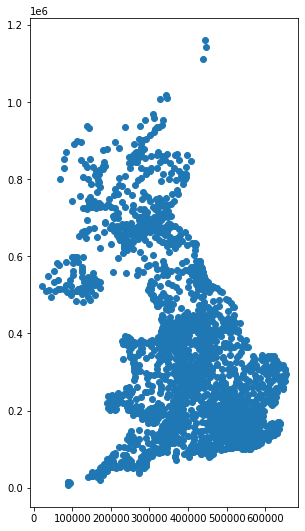

In [12]:
postcodes_gdf.plot(figsize=(9,9))

In [13]:
postcodes_gdf = postcodes_gdf.to_crs('epsg:32630')
postcodes_gdf.crs

<Derived Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

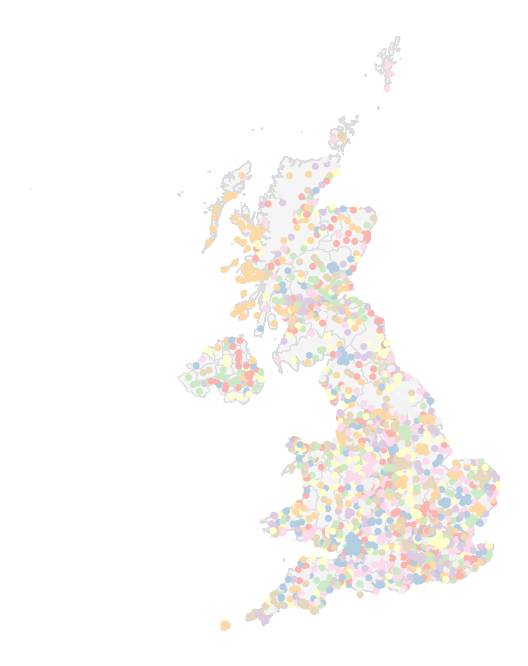

In [14]:
base = counties.plot(figsize=(12,12), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

postcodes_gdf.plot(ax=base, column='locality', cmap='Pastel1', zorder=1)

## UK Universities from UCAS

In [23]:
# Scrape from https://www.ucas.com/explore/unis?letter=<parameter>
start_url = 'https://www.ucas.com/explore/unis'
params = {'letter': None}
all_letters = string.ascii_lowercase
universities = []

# for letter in all_letters:
#     params['letter'] = letter
#     print(f'Getting all universities from letter {letter}')
#     response = requests.get(start_url, params=params)
#     results_soup = BeautifulSoup(response.content)
    
#     # get each university name and location
#     unis = results_soup.select('.link-container__link')
#     print(f'  Got {len(unis)}')
#     for uni in unis:
#         uni_name = uni.get('title')
#         uni_url = urljoin(start_url, uni.get('href'))
#         response = requests.get(uni_url)
#         uni_content_soup = BeautifulSoup(response.content)
#         location = uni_content_soup.select_one('.content-block__section.content-block__section--grow p').text
#         postcode = location.split(',')[-1]
    
#         uni_data = {'name': uni_name, 'url': uni_url, 'address': location, 'postcode': postcode}
#         universities.append(uni_data)

Getting all universities from letter a
  Got 14
Getting all universities from letter b
  Got 41
Getting all universities from letter c
  Got 28
Getting all universities from letter d
  Got 9
Getting all universities from letter e
  Got 15
Getting all universities from letter f
  Got 5
Getting all universities from letter g
  Got 12
Getting all universities from letter h
  Got 22
Getting all universities from letter i
  Got 4
Getting all universities from letter j
  Got 0
Getting all universities from letter k
  Got 7
Getting all universities from letter l
  Got 31
Getting all universities from letter m
  Got 9
Getting all universities from letter n
  Got 19
Getting all universities from letter o
  Got 4
Getting all universities from letter p
  Got 11
Getting all universities from letter q
  Got 3
Getting all universities from letter r
  Got 19
Getting all universities from letter s
  Got 38
Getting all universities from letter t
  Got 8
Getting all universities from letter u
  Got 16
G

In [26]:
# pd.DataFrame(universities).to_csv('datasets/UK/ucas_universities_2022.csv', index=False)

In [95]:
ucas_unis = pd.read_csv('datasets/UK/ucas_universities_2022.csv')
len(ucas_unis)

340

In [96]:
ucas_unis.head()

,name,url,address,postcode
0,University of Aberdeen,https://www.ucas.com/explore/unis/3a023828/uni...,"King's College, Aberdeen, AB24 3FX",AB24 3FX
1,Abertay University,https://www.ucas.com/explore/unis/1558119a/abe...,"Kydd Building, Bell Street, Dundee, Tayside, D...",DD1 1HG
2,Aberystwyth University,https://www.ucas.com/explore/unis/168d2cd8/abe...,"Penglais Campus, Penglais Campus, Aberystwyth,...",SY23 3FB
3,ACM (The Academy of Contemporary Music),https://www.ucas.com/explore/unis/3d3a3bb5/acm...,"The Rodboro Building, Bridge Street,, Guildfor...",GU1 4SB
4,Activate Learning,https://www.ucas.com/explore/unis/1630c359/act...,"Oxpens Road, Oxford, Oxfordshire, OX1 1SA",OX1 1SA


## Top UK universities

In [442]:
# Source: https://www.thecompleteuniversityguide.co.uk/league-tables/rankings
# Original download is .numbers, converted to .csv, with some manually deleted headers
rankings = pd.read_csv('datasets/UK/university_ranks.csv')
len(rankings)

130

In [443]:
rankings.head()

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895


In [444]:
top_unis = rankings.merge(ucas_unis, how='inner', right_on='name', left_on='Institution')
top_unis

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,126,University of Suffolk,110,3.96,NaN,NaN,74.4,80.9,16.5,1961,478,65.0,395,University of Suffolk,https://www.ucas.com/explore/unis/cf271b96/uni...,"Waterfront Building, Neptune Quay, Neptune Qua...",IP4 1QJ
125,127,University of East London,97,4.00,2.71,0.23,56.5,69.6,21.9,1105,756,76.5,374,University of East London,https://www.ucas.com/explore/unis/6d89f913/uni...,"University Way, London, London, E16 2RD",E16 2RD
126,128,"Glyndwr University, Wrexham",102,4.14,2.15,0.16,62.9,68.6,21.9,1334,559,73.3,364,"Glyndwr University, Wrexham",https://www.ucas.com/explore/unis/fdb6a3ab/gly...,"Mold Road, Mold Road, Wrexham, Denbighshire, L...",LL11 2AW
127,129,Ravensbourne University London,113,3.80,NaN,NaN,70.0,77.5,22.6,1163,322,79.7,333,Ravensbourne University London,https://www.ucas.com/explore/unis/6f003a01/rav...,"6 Penrose Way,, London, London, SE10 0EW",SE10 0EW


One university was not mathed with the rankings data - find what that is and insert into the top_unis

In [445]:
mask = rankings['Institution'].isin(ucas_unis['name'])

In [446]:
rankings[~mask]

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score
11,12,University of Edinburgh,186,3.86,3.18,0.83,79.6,78.8,11.7,1407,808,93.3,801


In [447]:
ucas_unis.loc[ucas_unis['name'].str.contains('Edinburgh')]

,name,url,address,postcode
99,Edinburgh Napier University,https://www.ucas.com/explore/unis/dc3ccbfc/edi...,"Merchiston Campus\r\n10 Colinton Road, Edinbur...",EH10 5DT
100,The University of Edinburgh,https://www.ucas.com/explore/unis/114bb2e7/the...,"Old College, South Bridge, Edinburgh, EH8 9YL",EH8 9YL
231,"Queen Margaret University, Edinburgh",https://www.ucas.com/explore/unis/403c3afa/que...,"Queen Margaret Drive, Edinburgh, Musselburgh, ...",EH21 6UU


In [448]:
df1 = ucas_unis.loc[ucas_unis['name'] == 'The University of Edinburgh'].reset_index(drop=True)
df2 = rankings.loc[rankings['Institution'] == 'University of Edinburgh'].reset_index(drop=True)
edinburgh = pd.concat([df2, df1], axis=1)
top_unis = pd.concat([top_unis, edinburgh], axis=0).reset_index(drop=True).sort_values(by='Rank')

In [449]:
len(top_unis)

130

In [450]:
top_unis.head()

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ


### Get outer postcode to join with postcodes and counties data

In [451]:
top_unis['outer_post_code'] = (
    top_unis['postcode'].str.strip().str.split(' ').apply(lambda x: x[0])
)

In [452]:
top_unis.head()

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode,outer_post_code
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD,OX1
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT,CB2
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE,WC2A
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX,KY16
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ,SW7


In [453]:
top_uni_locs = postcodes_gdf.merge(top_unis, how='inner', on='outer_post_code')
len(top_uni_locs)

129

In [454]:
# one top uni that did not match postcodes
mask = top_unis.loc[~top_unis['outer_post_code'].isin(postcodes_gdf['outer_post_code'])]
mask

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode,outer_post_code
36,38,University of Aberdeen,182,4.06,2.97,0.73,74.8,77.2,15.7,1744,701,88.5,686,University of Aberdeen,https://www.ucas.com/explore/unis/3a023828/uni...,"King's College, Aberdeen, AB24 3FX",AB24 3FX,AB24


In [455]:
# provisionally edit the outer_post_code of University of Aberdeen to match current postcodes data
top_unis.loc[top_unis['Institution'] == 'University of Aberdeen', 'outer_post_code'] = 'AB25'

In [456]:
# try merging top unis and postcodes again..
top_uni_locs = postcodes_gdf.merge(top_unis, how='inner', on='outer_post_code')
len(top_uni_locs)

130

In [457]:
top_uni_locs.head(2)

,outer_post_code,x,y,lat,long,locality,county,geometry,Rank,Institution,...,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode
0,AB25,393200,806900,57.15,-2.11,Aberdeen,Aberdeen,POINT (553598.848 6334757.088),38,University of Aberdeen,...,77.2,15.7,1744,701,88.5,686,University of Aberdeen,https://www.ucas.com/explore/unis/3a023828/uni...,"King's College, Aberdeen, AB24 3FX",AB24 3FX
1,AL10,522200,208300,51.76,-0.23,Hatfield,Hertfordshire,POINT (691103.814 5737980.591),80,University of Hertfordshire,...,74.3,15.6,1638,1122,82.0,545,University of Hertfordshire,https://www.ucas.com/explore/unis/e2cc6194/uni...,"University Admissions Service, College Lane, C...",AL10 9AB


In [458]:
# clean the counties
top_uni_locs['county'] = top_uni_locs['county'].str.strip()

In [459]:
top_uni_locs = top_uni_locs.sort_values(by='Rank')

## Map of top UK universities

In [460]:
top_uni_locs[:10]

,outer_post_code,x,y,lat,long,locality,county,geometry,Rank,Institution,...,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode
85,OX1,451100,205400,51.74,-1.25,Oxford,Oxfordshire,POINT (620037.782 5734105.007),1,University of Oxford,...,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD
20,CB2,545900,253800,52.16,0.13,Cambridge,Cambridgeshire,POINT (714181.392 5783814.040),2,University of Cambridge,...,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT
123,WC2A,530800,181400,51.51,-0.11,London,London,POINT (700073.661 5711194.374),3,London School of Economics and Political Scien...,...,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE
55,KY16,349400,716900,56.34,-2.81,Saint Andrews,Fife,POINT (511118.570 6244129.714),4,University of St Andrews,...,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX
110,SW7,526700,179100,51.49,-0.17,London,London,POINT (696004.478 5708837.943),5,Imperial College London,...,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ
33,DH1,427900,543000,54.78,-1.56,Durham,County Durham,POINT (592114.345 6071377.662),6,Durham University,...,82.3,13.5,2174,1085,96.8,889,Durham University,https://www.ucas.com/explore/unis/6e455568/dur...,"The Palatine Centre, Stockton Road, South Road...",DH1 3LE
63,LE11,452900,319400,52.76,-1.21,Loughborough,Leicestershire,POINT (620263.611 5848132.073),7,Loughborough University,...,83.0,13.5,1853,1375,93.4,868,Loughborough University,https://www.ucas.com/explore/unis/b935bbb7/lou...,"Epinal Way, Loughborough, Leicestershire, LE11...",LE11 3TU
120,WC1E,529600,181900,51.52,-0.13,London,London,POINT (698866.632 5711678.038),8,UCL (University College London),...,83.4,10.1,2338,325,94.3,854,UCL (University College London),https://www.ucas.com/explore/unis/bd0c70d8/ucl...,"Gower Street, London, London, WC1E 6BT",WC1E 6BT
29,CV4,429600,277900,52.39,-1.56,Coventry,West Midlands,POINT (597539.188 5806308.966),9,University of Warwick,...,81.5,12.8,1643,795,95.1,842,University of Warwick,https://www.ucas.com/explore/unis/e59d51a1/uni...,"University of Warwick, Coventry, West Midlands...",CV4 7AL
6,BA2,373800,162400,51.36,-2.37,Bath,Somerset,POINT (543329.084 5690049.840),10,University of Bath,...,85.6,15.1,1913,703,96.0,840,University of Bath,https://www.ucas.com/explore/unis/295cc6a3/uni...,"University of BathClaverton Down, Claverton Do...",BA2 7AY


In [718]:
top10 = top_uni_locs[:10]
top_counties = (top_uni_locs
                .groupby('county')
                .agg({'geometry': lambda x: x,
                      'lat': lambda x: x,
                      'long': lambda x: x,
                      'locality': lambda x: list(x),
                      'name': lambda x: list(x)})
                .reset_index())
top_counties['count'] = (
    top_counties['geometry'].apply(lambda x: len(x) if isinstance(x, gpd.array.GeometryArray) else 1))
top_counties['geometry'] = (
    top_counties['geometry'].apply(lambda x: x[0] if isinstance(x, gpd.array.GeometryArray) else x))
top_counties['lat'] = (
    top_counties['lat'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x))
top_counties['long'] = (
    top_counties['long'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x))
top_counties['locality'] = (
    top_counties['locality'].apply(lambda x: x[0].strip() if isinstance(x, list) else x.strip()))
top_counties['name'] = (
    top_counties['name'].apply(lambda x: ',\n'.join(y for y in x) if isinstance(x, list) else x.strip()))
# top_counties = gpd.GeoDataFrame(top_counties, geometry=top_counties['geometry'])

In [719]:
# merge top uni counties with counties to minimuse mismatches
matched_by_name = top_counties.merge(counties, how='inner', left_on='county', right_on='NAME_2')
unmatched_counties = top_counties.loc[~top_counties['county'].isin(matched_by_name['county'])]

matched_by_alt_name = unmatched_counties.merge(counties, how='inner', left_on='county', right_on='VARNAME_2')
matched_top_counties = pd.concat([matched_by_name, matched_by_alt_name], axis=0).reset_index(drop=True)

matched_top_counties = gpd.GeoDataFrame(matched_top_counties, geometry=matched_top_counties['geometry_y'])
matched_top_counties

,county,geometry_x,lat,long,locality,name,count,ID_0,ISO,NAME_0,...,CC_2,TYPE_2,ENGTYPE_2,VALIDFR_2,VALIDTO_2,REMARKS_2,Shape_Leng,Shape_Area,geometry_y,geometry
0,Aberdeen,POINT (553598.847716016 6334757.0878634835),57.15,-2.11,Aberdeen,"University of Aberdeen,\nRobert Gordon University",2,80,GBR,United Kingdom,...,None,Unitary District (city),Unitary District (city),1929,Present,None,1.009378,0.032908,"POLYGON ((548894.824 6343496.931, 549827.112 6...","POLYGON ((548894.824 6343496.931, 549827.112 6..."
1,Angus,POINT (501325.39148499625 6257387.813581432),56.46,-2.97,Dundee,"University of Dundee,\nAbertay University",2,80,GBR,United Kingdom,...,None,Unitary District,Unitary District,1929,Present,None,3.266633,0.309782,"POLYGON ((510283.864 6314460.933, 511723.756 6...","POLYGON ((510283.864 6314460.933, 511723.756 6..."
2,Bedfordshire,POINT (677230.3701700165 5750294.066540756),51.87,-0.42,Luton,University of Bedfordshire,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,~1989,Present,None,2.158565,0.147815,"POLYGON ((679380.073 5794077.687, 679674.028 5...","POLYGON ((679380.073 5794077.687, 679674.028 5..."
3,Berkshire,POINT (643699.9539630723 5700721.069649863),51.43,-0.93,Reading,University of Reading,1,80,GBR,United Kingdom,...,None,County,County,Between 1900 and 1974,Present,non-metropolitan county with no county council,2.825418,0.158283,"POLYGON ((658761.890 5714402.155, 659890.480 5...","POLYGON ((658761.890 5714402.155, 659890.480 5..."
4,Buckinghamshire,POINT (656016.4307577533 5721694.905267646),51.62,-0.74,High Wycombe,"Buckinghamshire New University,\nUniversity of...",2,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,~1989,Present,None,3.259887,0.204493,"POLYGON ((641147.796 5771041.153, 644006.239 5...","POLYGON ((641147.796 5771041.153, 644006.239 5..."
5,Cambridgeshire,POINT (714181.3920908907 5783814.039706429),52.16,0.13,Cambridge,"University of Cambridge,\nAnglia Ruskin Univer...",2,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.897993,0.403477,"POLYGON ((716566.133 5838210.639, 715449.582 5...","POLYGON ((716566.133 5838210.639, 715449.582 5..."
6,Ceredigion,POINT (428364.9400934233 5804068.845491355),52.38,-4.05,Aberystwyth,Aberystwyth University,1,80,GBR,United Kingdom,...,None,Unitary Authority (wales),Unitary Authority (wales,1888,Present,None,3.448064,0.247170,"MULTIPOLYGON (((384465.263 5777319.835, 384464...","MULTIPOLYGON (((384465.263 5777319.835, 384464..."
7,Cheshire,POINT (506100.48827969574 5894746.039051152),53.20,-2.90,Chester,University of Chester,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.391066,0.291374,"POLYGON ((526257.026 5909958.816, 527283.989 5...","POLYGON ((526257.026 5909958.816, 527283.989 5..."
8,Cornwall,POINT (350841.5241655942 5557358.2608969975),50.14,-5.08,Falmouth,Falmouth University,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,11.989156,0.455993,"MULTIPOLYGON (((256561.595 5529543.898, 256560...","MULTIPOLYGON (((256561.595 5529543.898, 256560..."
9,Denbighshire,POINT (497615.7196490202 5879327.277821805),53.06,-3.03,Wrexham,"Glyndwr University, Wrexham",1,80,GBR,United Kingdom,...,None,Unitary Authority (wales),Unitary Authority (wales,1888,Present,None,2.019631,0.111664,"POLYGON ((475130.578 5911348.442, 475130.419 5...","POLYGON ((475130.578 5911348.442, 475130.419 5..."


In [720]:
type(matched_top_counties)

geopandas.geodataframe.GeoDataFrame

In [721]:
matched_top_counties

,county,geometry_x,lat,long,locality,name,count,ID_0,ISO,NAME_0,...,CC_2,TYPE_2,ENGTYPE_2,VALIDFR_2,VALIDTO_2,REMARKS_2,Shape_Leng,Shape_Area,geometry_y,geometry
0,Aberdeen,POINT (553598.847716016 6334757.0878634835),57.15,-2.11,Aberdeen,"University of Aberdeen,\nRobert Gordon University",2,80,GBR,United Kingdom,...,None,Unitary District (city),Unitary District (city),1929,Present,None,1.009378,0.032908,"POLYGON ((548894.824 6343496.931, 549827.112 6...","POLYGON ((548894.824 6343496.931, 549827.112 6..."
1,Angus,POINT (501325.39148499625 6257387.813581432),56.46,-2.97,Dundee,"University of Dundee,\nAbertay University",2,80,GBR,United Kingdom,...,None,Unitary District,Unitary District,1929,Present,None,3.266633,0.309782,"POLYGON ((510283.864 6314460.933, 511723.756 6...","POLYGON ((510283.864 6314460.933, 511723.756 6..."
2,Bedfordshire,POINT (677230.3701700165 5750294.066540756),51.87,-0.42,Luton,University of Bedfordshire,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,~1989,Present,None,2.158565,0.147815,"POLYGON ((679380.073 5794077.687, 679674.028 5...","POLYGON ((679380.073 5794077.687, 679674.028 5..."
3,Berkshire,POINT (643699.9539630723 5700721.069649863),51.43,-0.93,Reading,University of Reading,1,80,GBR,United Kingdom,...,None,County,County,Between 1900 and 1974,Present,non-metropolitan county with no county council,2.825418,0.158283,"POLYGON ((658761.890 5714402.155, 659890.480 5...","POLYGON ((658761.890 5714402.155, 659890.480 5..."
4,Buckinghamshire,POINT (656016.4307577533 5721694.905267646),51.62,-0.74,High Wycombe,"Buckinghamshire New University,\nUniversity of...",2,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,~1989,Present,None,3.259887,0.204493,"POLYGON ((641147.796 5771041.153, 644006.239 5...","POLYGON ((641147.796 5771041.153, 644006.239 5..."
5,Cambridgeshire,POINT (714181.3920908907 5783814.039706429),52.16,0.13,Cambridge,"University of Cambridge,\nAnglia Ruskin Univer...",2,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.897993,0.403477,"POLYGON ((716566.133 5838210.639, 715449.582 5...","POLYGON ((716566.133 5838210.639, 715449.582 5..."
6,Ceredigion,POINT (428364.9400934233 5804068.845491355),52.38,-4.05,Aberystwyth,Aberystwyth University,1,80,GBR,United Kingdom,...,None,Unitary Authority (wales),Unitary Authority (wales,1888,Present,None,3.448064,0.247170,"MULTIPOLYGON (((384465.263 5777319.835, 384464...","MULTIPOLYGON (((384465.263 5777319.835, 384464..."
7,Cheshire,POINT (506100.48827969574 5894746.039051152),53.20,-2.90,Chester,University of Chester,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.391066,0.291374,"POLYGON ((526257.026 5909958.816, 527283.989 5...","POLYGON ((526257.026 5909958.816, 527283.989 5..."
8,Cornwall,POINT (350841.5241655942 5557358.2608969975),50.14,-5.08,Falmouth,Falmouth University,1,80,GBR,United Kingdom,...,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,11.989156,0.455993,"MULTIPOLYGON (((256561.595 5529543.898, 256560...","MULTIPOLYGON (((256561.595 5529543.898, 256560..."
9,Denbighshire,POINT (497615.7196490202 5879327.277821805),53.06,-3.03,Wrexham,"Glyndwr University, Wrexham",1,80,GBR,United Kingdom,...,None,Unitary Authority (wales),Unitary Authority (wales,1888,Present,None,2.019631,0.111664,"POLYGON ((475130.578 5911348.442, 475130.419 5...","POLYGON ((475130.578 5911348.442, 475130.419 5..."


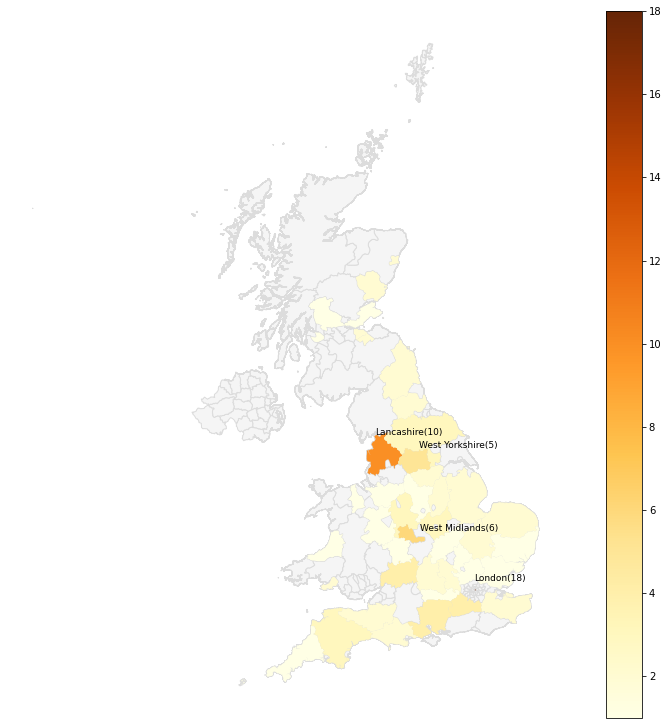

In [790]:
base = counties.plot(figsize=(15,13), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

matched_top_counties.plot(ax=base, column='count', cmap='YlOrBr', legend=True, zorder=1)

matched_top_counties['coords'] = (
    matched_top_counties['geometry_x'].apply(lambda x: x.representative_point().coords[:])
)
matched_top_counties['coords'] = [coords[0] for coords in matched_top_counties['coords']]

for idx, row in matched_top_counties.iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    plt.annotate(text=f"{row['county'] + '('+str(row['count'])+')' if row['count'] > 4 else ''}",
#                  text=f"{row['county']} ({row['name'] if row['count'] <= 2 else str(row['count']) + ' universities'})",
                 xy=(x,y-1e2),
#                  xytext=(x+4.2e5, y),
                 xytext=(x, y+3e4),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=9,
#                  arrowprops={'arrowstyle': '<-', 'color': 'dimgrey', 'linewidth': 0.4},
                 color='black')